In [3]:
%pylab inline
from IPython.display import Image, display
import PIL.Image
import matplotlib.image as mpimg
import scipy.ndimage
import cv2 # For Sobel etc
import glob
np.set_printoptions(suppress=True, linewidth=200) # Better printing of arrays
plt.rcParams['image.cmap'] = 'jet' # Default colormap is jet

from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread


Populating the interactive namespace from numpy and matplotlib


/home/alex/.local/lib/python3.5/site-packages/ipykernel_launcher.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/alex/.local/lib/python3.5/site-packages/ipykernel_launcher.py:268: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


[[ -3.35827714  26.15811585 309.56532301]
 [ 21.6165946   -5.68579936 246.69235563]
 [ -0.02263322  -0.00157414   1.        ]]


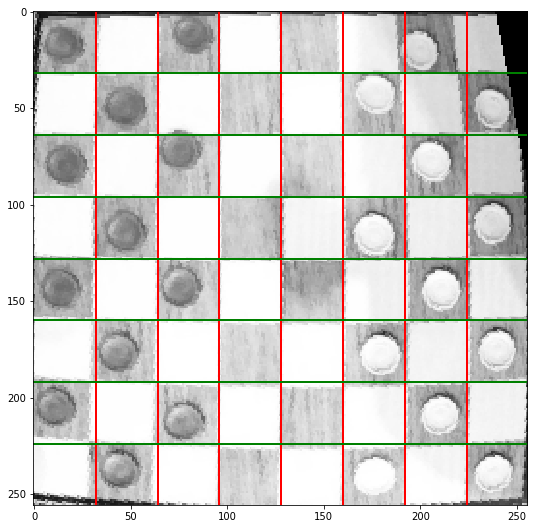

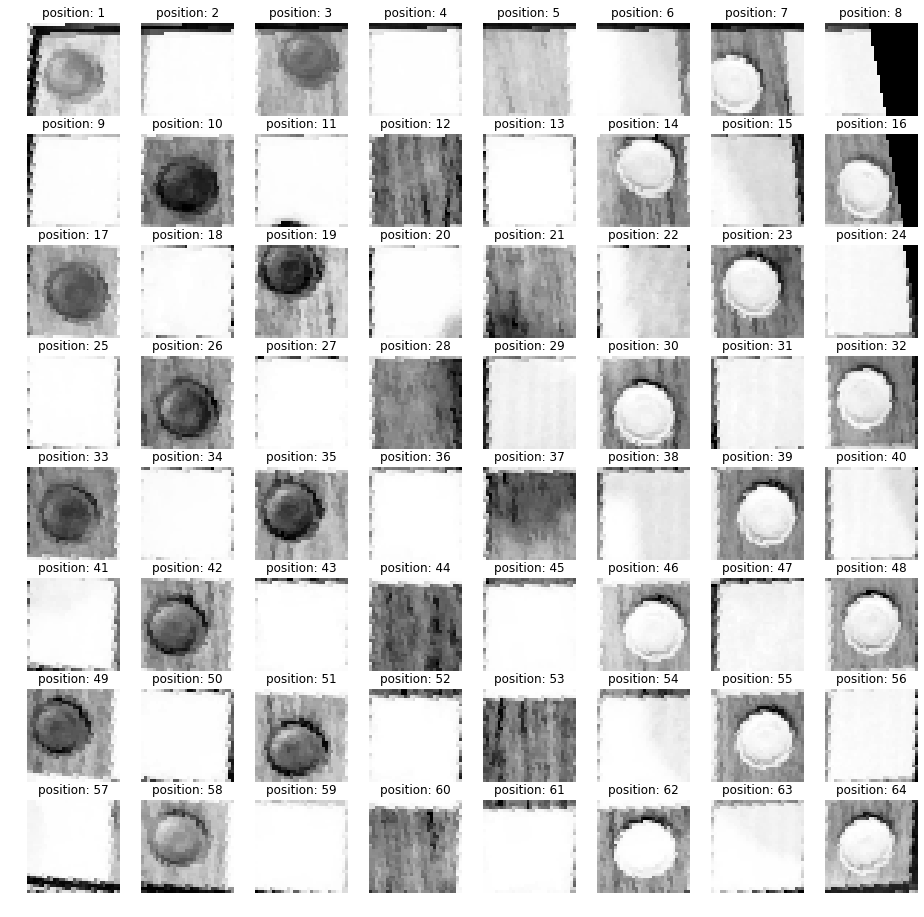

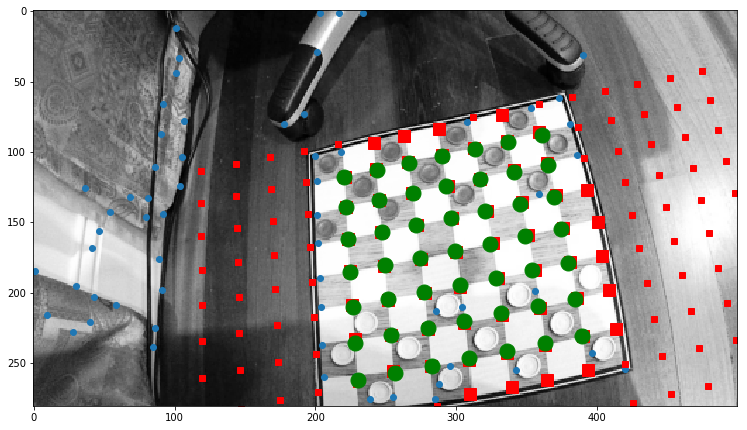

In [28]:

def getUnwarpedPoints(best_lines_x, best_lines_y, M):
    x,y = np.meshgrid(best_lines_x, best_lines_y)
    xy = np.vstack([x.flatten(), y.flatten()]).T.astype(np.float32)
    xy = np.expand_dims(xy,0)

    xy_unwarp = cv2.perspectiveTransform(xy, M)
    return xy_unwarp[0,:,:]

def getGrads(img):
    img = cv2.blur(img,(5,5))
    gx = cv2.Sobel(img,cv2.CV_64F,1,0)
    gy = cv2.Sobel(img,cv2.CV_64F,0,1)

    grad_mag = gx*gx+gy*gy
    grad_phase = np.arctan2(gy, gx) # from -pi to pi
    grad_phase_masked = grad_phase.copy()
    gradient_mask_threshold = 2*np.mean(grad_mag.flatten())
    grad_phase_masked[grad_mag < gradient_mask_threshold] = np.nan
    return grad_mag, grad_phase_masked, grad_phase, gx, gy

# grad_mag, grad_phase_masked, grad_phase, gx, gy = getGrads(img_warp)

def getBestLines(img_warped):
    grad_mag, grad_phase_masked, grad_phase, gx, gy = getGrads(img_warped)
    
    # X
    gx_pos = gx.copy()
    gx_pos[gx_pos < 0] = 0
    gx_neg = -gx.copy()
    gx_neg[gx_neg < 0] = 0
    score_x = np.sum(gx_pos, axis=0) * np.sum(gx_neg, axis=0)
    # Y
    gy_pos = gy.copy()
    gy_pos[gy_pos < 0] = 0
    gy_neg = -gy.copy()
    gy_neg[gy_neg < 0] = 0
    score_y = np.sum(gy_pos, axis=1) * np.sum(gy_neg, axis=1)
    
    # Choose best internal set of 7
    a = np.array([(offset + np.arange(7) + 1)*32 for offset in np.arange(1,11-2)])
    scores_x = np.array([np.sum(score_x[pts]) for pts in a])
    scores_y = np.array([np.sum(score_y[pts]) for pts in a])
    
    # 15x15 grid, so along an axis a set of 7, and an internal 7 at that, so 13x13 grid, 7x7 possibility inside
    # We're also using a 1-padded grid so 17x17 grid
    # We only want the internal choices (13-7) so 6x6 possible options in the 13x13 
    # so 2,3,4,5,6,7,8 to 8,9,10,11,12,13,14 ignoring 0,1 and 15,16,17
    best_lines_x = a[scores_x.argmax()]
    best_lines_y = a[scores_y.argmax()]
    return (best_lines_x, best_lines_y)
def getIdentityGrid(N):
    a = np.arange(N)
    b = a.copy()
    aa,bb = np.meshgrid(a,b)
    return np.vstack([aa.flatten(), bb.flatten()]).T

def getChessGrid(quad):
    quadA = np.array([[0,1],[1,1],[1,0],[0,0]],dtype=np.float32)
    M = cv2.getPerspectiveTransform(quadA, quad.astype(np.float32))
    quadB = getIdentityGrid(4)-1
    quadB_pad = np.pad(quadB, ((0,0),(0,1)), 'constant', constant_values=1)
    C_thing = (np.matrix(M)*quadB_pad.T).T
#     bad = (C_thing[:,2] < 0.3).A.flatten()
    C_thing[:,:2] /= C_thing[:,2]
    return C_thing



def getMinSaddleDist(saddle_pts, pt):
    best_dist = None
    best_pt = pt
    for saddle_pt in saddle_pts:
        saddle_pt = saddle_pt[::-1]
        dist = np.sum((saddle_pt - pt)**2)
        if best_dist is None or dist < best_dist:
            best_dist = dist
            best_pt = saddle_pt
    return best_pt, np.sqrt(best_dist)

def findGoodPoints(grid, spts, max_px_dist=5):
    # Snap grid points to closest saddle point within range and return updated
    # grid = Nx2 points on grid
    new_grid = grid.copy()
    chosen_spts = set()
    N = len(new_grid)
    grid_good = np.zeros(N,dtype=np.bool)
    hash_pt = lambda pt: "%d_%d" % (pt[0], pt[1])
    
    for pt_i in range(N):
        pt2, d = getMinSaddleDist(spts, grid[pt_i,:2].A.flatten())
        if hash_pt(pt2) in chosen_spts:
            d = max_px_dist
        else:
            chosen_spts.add(hash_pt(pt2))
        if (d < max_px_dist): # max dist to replace with
            new_grid[pt_i,:2] = pt2
            grid_good[pt_i] = True
    return new_grid, grid_good

def getInitChessGrid(quad):
    quadA = np.array([[0,1],[1,1],[1,0],[0,0]],dtype=np.float32)
    M = cv2.getPerspectiveTransform(quadA, quad.astype(np.float32))
    return makeChessGrid(M,1)

def makeChessGrid(M, N=1):
    ideal_grid = getIdentityGrid(2+2*N)-N
    ideal_grid_pad = np.pad(ideal_grid, ((0,0),(0,1)), 'constant', constant_values=1) # Add 1's column
    # warped_pts = M*pts
    grid = (np.matrix(M)*ideal_grid_pad.T).T
    grid[:,:2] /= grid[:,2] # normalize by t
    grid = grid[:,:2] # remove 3rd column
    return grid, ideal_grid, M

def generateNewBestFit(grid_ideal, grid, grid_good):
    a = np.float32(grid_ideal[grid_good])
    b = np.float32(grid[grid_good])
    M = cv2.findHomography(a, b, cv2.RANSAC)
    return M
def updateCorners(contour, saddle):
#     print(contour)
    ws = 4 # half window size (+1)
    new_contour = contour.copy()
    for i in range(len(contour)):
#         print(i, contour[i,0,:])
        cc,rr = contour[i,0,:]
        rl = max(0,rr-ws)
        cl = max(0,cc-ws)
        window = saddle[rl:min(saddle.shape[0],rr+ws+1),cl:min(saddle.shape[1],cc+ws+1)]
#         window = saddle[rr-ws:rr+ws+1,cc-ws:cc+ws+1]
#         print(window.astype(np.int)/1000)
        br, bc = np.unravel_index(window.argmax(), window.shape)
        s_score = window[br,bc]
        br -= min(ws,rl)
        bc -= min(ws,cl)
#         print(s_score, br, bc)
        if s_score > 0:
            new_contour[i,0,:] = cc+bc,rr+br
        else:
#             print("no saddle")
            return []
    return new_contour

def simplifyContours(contours):
  for i in range(len(contours)):
    # Approximate contour and update in place
    contours[i] = cv2.approxPolyDP(contours[i],0.04*cv2.arcLength(contours[i],True),True)

def is_square(cnt, eps=3.0, xratio_thresh = 0.5):
  # 4x2 array, rows are each point, columns are x and y
  center = cnt.sum(axis=0)/4

  # Side lengths of rectangular contour
  dd0 = np.sqrt(((cnt[0,:] - cnt[1,:])**2).sum())
  dd1 = np.sqrt(((cnt[1,:] - cnt[2,:])**2).sum())
  dd2 = np.sqrt(((cnt[2,:] - cnt[3,:])**2).sum())
  dd3 = np.sqrt(((cnt[3,:] - cnt[0,:])**2).sum())

  # diagonal ratio
  xa = np.sqrt(((cnt[0,:] - cnt[2,:])**2).sum())
  xb = np.sqrt(((cnt[1,:] - cnt[3,:])**2).sum())
  xratio = xa/xb if xa < xb else xb/xa

  # Check whether all points part of convex hull
  # ie. not this http://i.stack.imgur.com/I6yJY.png
  # all corner angles, angles are less than 180 deg, so not necessarily internal angles
  ta = getAngle(dd3, dd0, xb) 
  tb = getAngle(dd0, dd1, xa)
  tc = getAngle(dd1, dd2, xb)
  td = getAngle(dd2, dd3, xa)
  angle_sum = np.round(ta+tb+tc+td)

  is_convex = np.abs(angle_sum - 360) < 5

  angles = np.array([ta,tb,tc,td])
  good_angles = np.all((angles > 40) & (angles < 140))


  # side ratios
  dda = dd0 / dd1
  if dda < 1:
    dda = 1. / dda
  ddb = dd1 / dd2
  if ddb < 1:
    ddb = 1. / ddb
  ddc = dd2 / dd3
  if ddc < 1:
    ddc = 1. / ddc
  ddd = dd3 / dd0
  if ddd < 1:
    ddd = 1. / ddd
  side_ratios = np.array([dda,ddb,ddc,ddd])
  good_side_ratios = np.all(side_ratios < eps)

  # Return whether side ratios within certain ratio < epsilon
  return (
    # abs(1.0 - dda) < eps and 
    # abs(1.0 - ddb) < eps and
    # xratio > xratio_thresh and 
    # good_side_ratios and
    # is_convex and
    good_angles)
    
def getAngle(a,b,c):
  # Get angle given 3 side lengths, in degrees
  k = (a*a+b*b-c*c) / (2*a*b)
  # Handle floating point errors
  if (k < -1):
    k=-1
  elif k > 1:
    k=1
  return np.arccos(k) * 180.0 / np.pi

def getContourVals(cnt, img):
    cimg = np.zeros_like(img)
    cv2.drawContours(cimg, [cnt], 0, color=255, thickness=-1)
    return img[cimg!=0]

def pruneContours(contours, hierarchy, saddle):
  new_contours = []
  new_hierarchies = []
  for i in range(len(contours)):
    cnt = contours[i]
    h = hierarchy[i]
    
    # Must be child
    if h[2] != -1:
        continue
    
    # Only rectangular contours allowed
    if len(cnt) != 4:
      continue
        
    # Only contours that fill an area of at least 8x8 pixels
    if cv2.contourArea(cnt) < 8*8:
      continue

    if not is_square(cnt):
      continue
    
    # TODO : Remove those where internal luma variance is greater than threshold
    
    cnt = updateCorners(cnt, saddle)
    # If not all saddle corners
    if len(cnt) != 4:
        continue

    new_contours.append(cnt)
    new_hierarchies.append(h)
  new_contours = np.array(new_contours)
  new_hierarchy = np.array(new_hierarchies)
  if len(new_contours) == 0:
    return new_contours, new_hierarchy
  
#   norm_contours = new_contours[:,:,0,:] - new_contours[:,[0],0,:]
#   median_contour = np.median(norm_contours, axis=0).astype(int)
#   diff = np.sqrt(np.sum((norm_contours - median_contour)**2,axis=2))

#   mask=np.all(diff < 60, axis=1)
# #   print(mask.shape)
#   new_contours = new_contours[mask]
#   new_hierarchy = new_hierarchy[mask]

  # Prune contours below median area
  areas = [cv2.contourArea(c) for c in new_contours]
  mask = [areas >= np.median(areas)*0.25] and [areas <= np.median(areas)*2.0]
  new_contours = new_contours[mask]
  new_hierarchy = new_hierarchy[mask]
  return np.array(new_contours), np.array(new_hierarchy)

def getContours(img, edges, iters=10):
    # Morphological Gradient to get internal squares of canny edges. 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    edges_gradient = cv2.morphologyEx(edges, cv2.MORPH_GRADIENT, kernel)
    _, contours, hierarchy = cv2.findContours(edges_gradient, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    simplifyContours(contours)  
    
    return np.array(contours), hierarchy[0]

def nonmax_sup(img, win=10):
    w, h = img.shape
#     img = cv2.blur(img, ksize=(5,5))
    img_sup = np.zeros_like(img, dtype=np.float64)
    for i,j in np.argwhere(img):
        # Get neigborhood
        ta=max(0,i-win)
        tb=min(w,i+win+1)
        tc=max(0,j-win)
        td=min(h,j+win+1)
        cell = img[ta:tb,tc:td]
        val = img[i,j]
        if np.sum(cell.max() == cell) > 1:
            print(cell.argmax())
        if cell.max() == val:
            img_sup[i,j] = val
    return img_sup

def getSaddle(gray_img):
    img = gray_img.astype(np.float64)
    gx = cv2.Sobel(img,cv2.CV_64F,1,0)
    gy = cv2.Sobel(img,cv2.CV_64F,0,1)
    gxx = cv2.Sobel(gx,cv2.CV_64F,1,0)
    gyy = cv2.Sobel(gy,cv2.CV_64F,0,1)
    gxy = cv2.Sobel(gx,cv2.CV_64F,0,1)
    
    S = gxx*gyy - gxy**2
    return S

def pruneSaddle(s):
    thresh = 128
    score = (s>0).sum()
    while (score > 10000):
        thresh = thresh*2
        s[s<thresh] = 0
        score = (s>0).sum()

def getBoardOutlinewarped(best_lines_x, best_lines_y, M):
    d = best_lines_x[1] - best_lines_x[0]
    ax = [best_lines_x[0]-d, best_lines_x[-1]+d]
    ay = [best_lines_y[0]-d, best_lines_y[-1]+d]
    x,y = np.meshgrid(ax, ay)
    xy = np.vstack([x.flatten(), y.flatten()]).T.astype(np.float32)
    xy = xy[[0,1,3,2,0],:]
    xy = np.expand_dims(xy,0)

    return xy[0,:,:]

def loadImage(filepath):
    img_orig = PIL.Image.open(filepath)
    img_width, img_height = img_orig.size

    # Resize
    aspect_ratio = min(500.0/img_width, 500.0/img_height)
    new_width, new_height = ((np.array(img_orig.size) * aspect_ratio)).astype(int)
    img = img_orig.resize((new_width,new_height), resample=PIL.Image.BILINEAR)
    img = img.convert('L') # grayscale
    img = np.array(img)
    
    return img

def findChessboard(img, min_pts_needed=15, max_pts_needed=25):
    blur_img = cv2.blur(img, (3,3)) # Blur it
    saddle = getSaddle(blur_img)
    saddle = -saddle
    saddle[saddle<0] = 0
    pruneSaddle(saddle)
    s2 = nonmax_sup(saddle)
    s2[s2<100000]=0
    spts = np.argwhere(s2)

    edges = cv2.Canny(img, 20, 250)
    contours_all, hierarchy = getContours(img, edges)
    contours, hierarchy = pruneContours(contours_all, hierarchy, saddle)
    
    curr_num_good = 0
    curr_grid_next = None
    curr_grid_good = None
    curr_M = None

    for cnt_i in range(len(contours)):
        #print ("On Contour %d" % cnt_i)
        cnt = contours[cnt_i].squeeze()
        grid_curr, ideal_grid, M = getInitChessGrid(cnt)

        for grid_i in range(7):
            grid_curr, ideal_grid, _ = makeChessGrid(M, N=(grid_i+1))
            grid_next, grid_good = findGoodPoints(grid_curr, spts)
            num_good = np.sum(grid_good)
            #print('I %d (N=%d), num_good: %d of %d' % (grid_i, grid_i+1, num_good, grid_good.size))
            if num_good < 4:
                M = None
                #print ("Failed to converge on this one")
                break
            M, _ = generateNewBestFit(ideal_grid, grid_next, grid_good)
            # Check that a valid and reasonable M was returned
            if M is None or np.abs(M[0,0] / M[1,1]) > 15 or np.abs(M[1,1] / M[0,0]) > 15:
#             if M is None:
                M = None
                #print ("Failed to converge on this one")
                break
        if M is None:
            continue
        elif num_good > curr_num_good:
            curr_num_good = num_good
            curr_grid_next = grid_next
            curr_grid_good = grid_good
            curr_M = M

        # If we found something with more than max needed, good enough to stop here
        if num_good > max_pts_needed:
            break
            
    # If we found something
    if curr_num_good > min_pts_needed:
        final_ideal_grid = getIdentityGrid(2+2*7)-7
        return curr_M, final_ideal_grid, curr_grid_next, curr_grid_good, spts
    else:
        return None, None, None, None, None
#     return M, ideal_grid, grid_next, grid_good, spts



def get_cutupp(fn):    

    img = loadImage(fn)
    M, ideal_grid, grid_next, grid_good, spts = findChessboard(img)
    print(M)

    # View
    if M is not None:
        M, _ = generateNewBestFit((ideal_grid+8)*32, grid_next, grid_good) # generate mapping for warping image
    #     print(M)
        img_warp = cv2.warpPerspective(img, M, (17*32, 17*32), flags=cv2.WARP_INVERSE_MAP)

        best_lines_x, best_lines_y = getBestLines(img_warp)
        xy_unwarp = getUnwarpedPoints(best_lines_x, best_lines_y, M)


        plt.figure(figsize=(20,20))
        plt.subplot(212)

        #Created the function getBoardOutlinewarped that would give the correct coordinates for the board border
        #in the wrapped setup, then will use that square bot to crop out the rest of the image and update
        #The coordinates of the the horizontal and vertical lines going thru the board , defining the cells
        #using the lines we finally use a double for loop to separate each cell into its own object, then 
        # We store it in a dictionary storing them using their positions as their key values ranging from 
        #1 to 64
        board_outline_unwarp = getBoardOutlinewarped(best_lines_x, best_lines_y, M)
        x_cord = []
        y_cord = []
        for pair in board_outline_unwarp[:4]:
            x_cord.append(pair[0])
            y_cord.append(pair[1])

        x1 = int(min(x_cord))
        y1 = int(min(y_cord))
        x2 = int(max(x_cord))
        y2 = int(max(y_cord))
        img_warp_cropped = img_warp[y1:y2, x1:x2]
        imshow(img_warp_cropped, cmap='Greys_r')
    #     print(best_lines_x)
    #     plt.plot(board_outline_unwarp[:,0] - x1, board_outline_unwarp[:,1] - y1, 'ro-', markersize=5, linewidth=3)
        [plt.axvline(line - x1, color='red', lw=2) for line in best_lines_x];
        [plt.axhline(line - y1, color='green', lw=2) for line in best_lines_y];
        fig = figure(figsize=(16, 16))

        best_lines_x = np.append(best_lines_x, [x2])
        best_lines_y = np.append(best_lines_y, [y2])
        checkerboard_cells = {}
        for i in range(len(best_lines_x)):
            vert_line = best_lines_x[i] - x1
            prev_vert_line = best_lines_x[i - 1] - x1 if i - 1 >= 0 else 0
            for j in range(len(best_lines_y)):
                horz_line = best_lines_y[j] - y1
                prev_horz_line = best_lines_y[j - 1] - y1 if j - 1 >= 0 else 0
                cell = img_warp_cropped[prev_horz_line:horz_line, prev_vert_line:vert_line]

                fig.add_subplot(8, 8, j * 8 + i + 1)
                plt.title("position: " + str(j * 8 + i + 1))
                plt.axis('off')
                checkerboard_cells[j * 8 + i + 1] = cell
                imshow(cell, cmap='Greys_r')


        figure(figsize=(16, 16))
        plt.subplot(211)
        axs = plt.axis()
        imshow(img, cmap='Greys_r');
        axs = plt.axis()
        plt.plot(spts[:,1],spts[:,0],'o')
        plt.plot(grid_next[:,0].A, grid_next[:,1].A,'rs')
        plt.plot(grid_next[grid_good,0].A, grid_next[grid_good,1].A,'rs', markersize=12)
        plt.plot(xy_unwarp[:,0], xy_unwarp[:,1], 'go', markersize=15)
        plt.axis(axs)
    return checkerboard_cells
    
in1 = get_cutupp('input/check10.jpg')

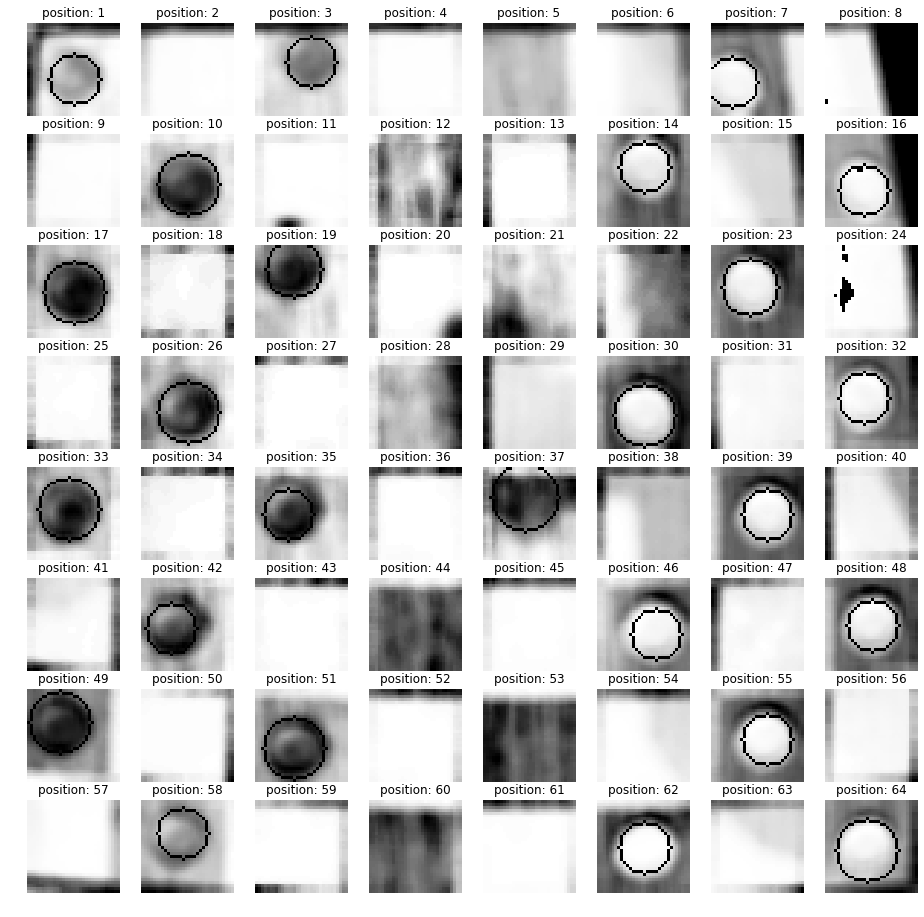

[[114.   0.  75.   0.   0.   0. 176.   0.]
 [  0.  22.   0.   0.   0. 102.   0. 226.]
 [ 15.   0.  14.   0.   0.   0. 124.   0.]
 [  0.  23.   0.   0.   0.  99.   0. 166.]
 [ 22.   0.  17.   0.  13.   0. 131.   0.]
 [  0.  26.   0.   0.   0. 132.   0. 111.]
 [ 16.   0.  25.   0.   0.   0. 126.   0.]
 [  0.  93.   0.   0.   0.  99.   0. 145.]]


array([[ 1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  1.,  0.,  1.],
       [-1.,  0., -1.,  0.,  0.,  0.,  1.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  1.,  0.,  1.],
       [-1.,  0., -1.,  0., -1.,  0.,  1.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  1.,  0.,  1.],
       [-1.,  0., -1.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.]])

In [30]:
from sklearn.cluster import KMeans

def identify_peices(cells):
    
    fig = figure(figsize=(16, 16))
    
    board = np.zeros((8, 8))
    
    for i in range(8):
        for j in range(8):
            key = j * 8 + i + 1
            cimg = cells[key].copy()

            cimg = cv2.blur(cimg,(5,5))
            cimg = ((cimg - np.min(cimg)) / np.max(cimg)) * 256
            cimg = np.around(cimg).astype(np.uint8)
            circles = cv2.HoughCircles(cimg, cv2.HOUGH_GRADIENT,  dp=1.5, minDist=60, param1=100, param2=15, \
                                       minRadius=8, maxRadius=15)

            if circles is None:
                fig.add_subplot(8, 8, j * 8 + i + 1)
                plt.title("position: " + str(j * 8 + i + 1))
                plt.axis('off')
                imshow(cimg, cmap='Greys_r')
                #plt.show()
                continue
                

            circles = np.uint16(np.around(circles))
            for vec in circles[0,:]:
                #print(key, vec)
                # draw the outer circle
                cv2.circle(cimg,(vec[0],vec[1]),vec[2],(0,255,0),1)
                # draw the center of the circle
                #cv2.circle(cimg,(vec[0],vec[1]), 1,(0,0,255), 1)
                
                height, width = cimg.shape
                mask = np.zeros((height,width), np.uint8)
                circle_img = cv2.circle(mask,(vec[0],vec[1]),vec[2],(255,255,255),thickness=-1)
                
                masked_data = cv2.bitwise_and(cimg, 
                                              cimg, 
                                              mask=circle_img)
                
                #print(np.mean(masked_data, where=circle_img.astype(bool)))
                
                masked_data = np.ma.masked_array(masked_data, mask=~circle_img.astype(bool))
                #print(masked_data)
                board[j, i] = np.median(masked_data.compressed()) #.median()
                
                
            
            fig.add_subplot(8, 8, j * 8 + i + 1)
            plt.title("position: " + str(j * 8 + i + 1))
            plt.axis('off')
            imshow(cimg, cmap='Greys_r')
    plt.show()
    print(board)
    
#     kmeans = KMeans(n_clusters=3).fit(board.flatten().reshape(-1, 1))
#     board = kmeans.labels_.reshape(8,8)
#     print(board)
#     board[board==2] = -1
    board[board > 50] = 1
    board[np.logical_and(board > 1, board <= 50)] = -1
    return board
    
identify_peices(in1)

In [25]:
import sys
sys.path.append("..")
from checkers import CheckerGame